## Load imports and functions

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pmdarima as pmd
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import calendar
from datetime import datetime, timedelta
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse
from statsmodels.tsa.arima.model import ARIMA

from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse

In [3]:
def convert_raw_data(dataframe):
    dataframe['Date'] = pd.to_datetime(dataframe['Date'])
    dataframe['Open'] = dataframe['Open'].replace({',': ''}, regex=True).apply(pd.to_numeric)
    dataframe['Price'] = dataframe['Price'].replace({',': ''}, regex=True).apply(pd.to_numeric)
    dataframe['High'] = dataframe['High'].replace({',': ''}, regex=True).apply(pd.to_numeric)
    dataframe['Low'] = dataframe['Low'].replace({',': ''}, regex=True).apply(pd.to_numeric)
    dataframe = dataframe.sort_values(by='Date', ascending=True).reset_index(drop=True)
    return dataframe

In [4]:

def create_weekdays_december_january_dataframe():
    start_date = datetime(2023, 12, 16)
    end_date = datetime(2024, 1, 31)
    date_range = pd.date_range(start_date, end_date)
    df = pd.DataFrame({"Date": date_range})
    df = df[(df["Date"].dt.dayofweek != 5) & (df["Date"].dt.dayofweek != 6)]
    new_df = pd.DataFrame({"Date": df["Date"].dt.strftime('%Y-%m-%d')})
    new_df = new_df.head(30)
    return new_df


## Load and convert data

In [7]:
df = pd.read_csv("VNI.csv")

In [5]:
df = convert_raw_data(df)
df.head(5)

,Date,Price,Open,High,Low,Vol.,Change %
0,2010-01-04,54.79,53.82,54.88,53.26,0.31K,1.80%
1,2010-01-05,54.45,55.05,55.22,54.07,0.36K,-0.62%
2,2010-01-06,54.22,54.35,54.56,52.97,0.36K,-0.42%
3,2010-01-07,53.33,54.18,54.80,53.21,0.28K,-1.64%
4,2010-01-08,51.82,52.98,53.27,51.60,0.24K,-2.83%


## split training and testing data

In [8]:
ratio = 0.7
ratio = 0.8
ratio = 0.9
train_size = int(ratio * len(df))
test_size = int((1-ratio) * len(df))


train_data = df[:train_size]
test_data = df[train_size:]

## process data using logarithmic transformation

In [7]:
filtered_data = train_data[['Date', 'Open']].copy()
Q1 = filtered_data['Open'].quantile(0.25)
Q3 = filtered_data['Open'].quantile(0.75)
IQR = Q3 - Q1
threshold = 1.5
df_no_outliers = filtered_data[~((filtered_data['Open'] < (Q1 - threshold * IQR)) | (filtered_data['Open'] > (Q3 + threshold * IQR)))]

## Training modal

In [8]:
df_no_outliers['Open_Log'] = np.log(df_no_outliers['Open'])
df_no_outliers.set_index('Date', inplace=True)

C:\Users\PH315-52\AppData\Local\Temp\ipykernel_21656\2609978933.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_no_outliers['Open_Log'] = np.log(df_no_outliers['Open'])


In [9]:
auto_arima1 = pmd.auto_arima(df_no_outliers['Open_Log'], start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, m=12,
                         start_P=0, seasonal=True,
                         d=None, D=0, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

Performing stepwise search to minimize aic


 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=-15132.640, Time=0.96 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-15080.526, Time=0.26 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-15126.776, Time=2.46 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-15121.518, Time=1.93 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-15082.516, Time=0.14 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=-15128.831, Time=0.26 sec
 ARIMA(1,1,1)(1,0,1)[12] intercept   : AIC=-15130.763, Time=2.42 sec
 ARIMA(1,1,1)(0,0,2)[12] intercept   : AIC=-15131.100, Time=7.08 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=-15132.192, Time=1.10 sec
 ARIMA(1,1,1)(1,0,2)[12] intercept   : AIC=-15129.017, Time=10.01 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-15126.910, Time=2.39 sec
 ARIMA(2,1,1)(0,0,1)[12] intercept   : AIC=-15130.763, Time=1.23 sec
 ARIMA(1,1,2)(0,0,1)[12] intercept   : AIC=-15130.762, Time=2.67 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=-15081.788, Time=0.93 sec
 ARIMA(0,1,2)(0,0,1)[12] intercep

In [10]:
auto_arima1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                 2407
Model:             SARIMAX(1, 1, 1)x(0, 0, 1, 12)   Log Likelihood                7571.316
Date:                            Mon, 01 Jan 2024   AIC                         -15134.632
Time:                                    08:11:47   BIC                         -15111.489
Sample:                                         0   HQIC                        -15126.214
                                           - 2407                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4952      0.065      7.566      0.000       0.367       0.624
ma.L1         -0.3656      0.069     -5.274      0.000      -0.501      -0.230
ma.S.L12      -0.0512      0.014     -3.545      0.000      -0.080      -0.023
sigma2         0.0001   1.32e-06     82.187      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              9757.77
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               0.37   Skew:                            -0.43
Prob(H) (two-sided):                  0.00   Kurtosis:                        12.83
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Evaluating

In [11]:
history = [np.log(x) for x in train_data['Open']]
prediction_test = list()
y_test = list(np.log(test_data['Open']))
for t in range(len(test_data)):
    model = ARIMA(history, order=(0,1,0), seasonal_order = (1,0,0,12))
    model_fit = model.fit()
    yhat_p = model_fit.predict(start=(len(history)+1), end=(len(history)+2))[0]
    prediction_test.append(yhat_p)
    history.append(y_test[t])

c:\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retv

In [13]:
prediction = np.exp(prediction_test)
predicted_df = pd.DataFrame({'Date': test_data['Date'], 'Open': prediction})

print(predicted_df)

           Date       Open
2438 2019-10-14  56.595023
2439 2019-10-15  56.956329
2440 2019-10-16  56.785806
2441 2019-10-17  56.611675
2442 2019-10-18  56.490000
...         ...        ...
3479 2023-12-11  85.745876
3480 2023-12-12  85.739454
3481 2023-12-13  85.502667
3482 2023-12-14  85.369546
3483 2023-12-15  85.044634

[1046 rows x 2 columns]


In [14]:
mae = mean_absolute_error(test_data['Open'], prediction)
mse = mean_squared_error(test_data['Open'], prediction)
mape = mean_absolute_percentage_error(test_data['Open'], prediction)
rmse = np.sqrt(mse)

print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'MAPE: {mape}')

MAE: 0.5441310093448908
MSE: 0.6703638724550113
RMSE: 0.8187575174952663
MAPE: 0.0068126542951482665


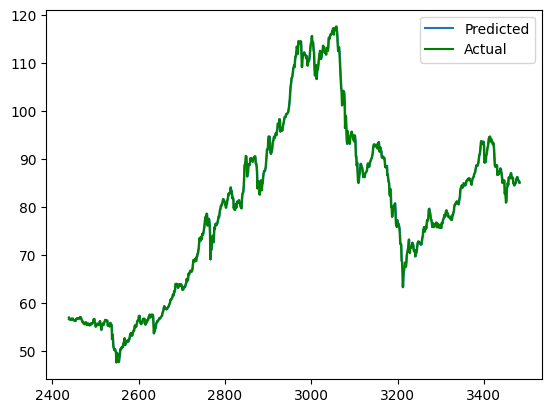

In [15]:
plt.plot(predicted_df['Open'], label = 'Predicted')
plt.plot(test_data['Open'], label='Actual', color = 'green')
plt.legend()
plt.show()

## Forecasting 

In [17]:
fredict_day = 30
history = [np.log(x) for x in df['Open']]
future_30_days = list()
y_test = list(np.log(df['Open']))
for t in range(fredict_day):
    model = ARIMA(history, order=(0,1,0), seasonal_order = (1,0,0,12))
    model_fit = model.fit()
    yhat_p = model_fit.predict(start=(len(history)+1), end=(len(history)+2))[0]
    future_30_days.append(np.exp(yhat_p))
    history.append(yhat_p)

c:\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


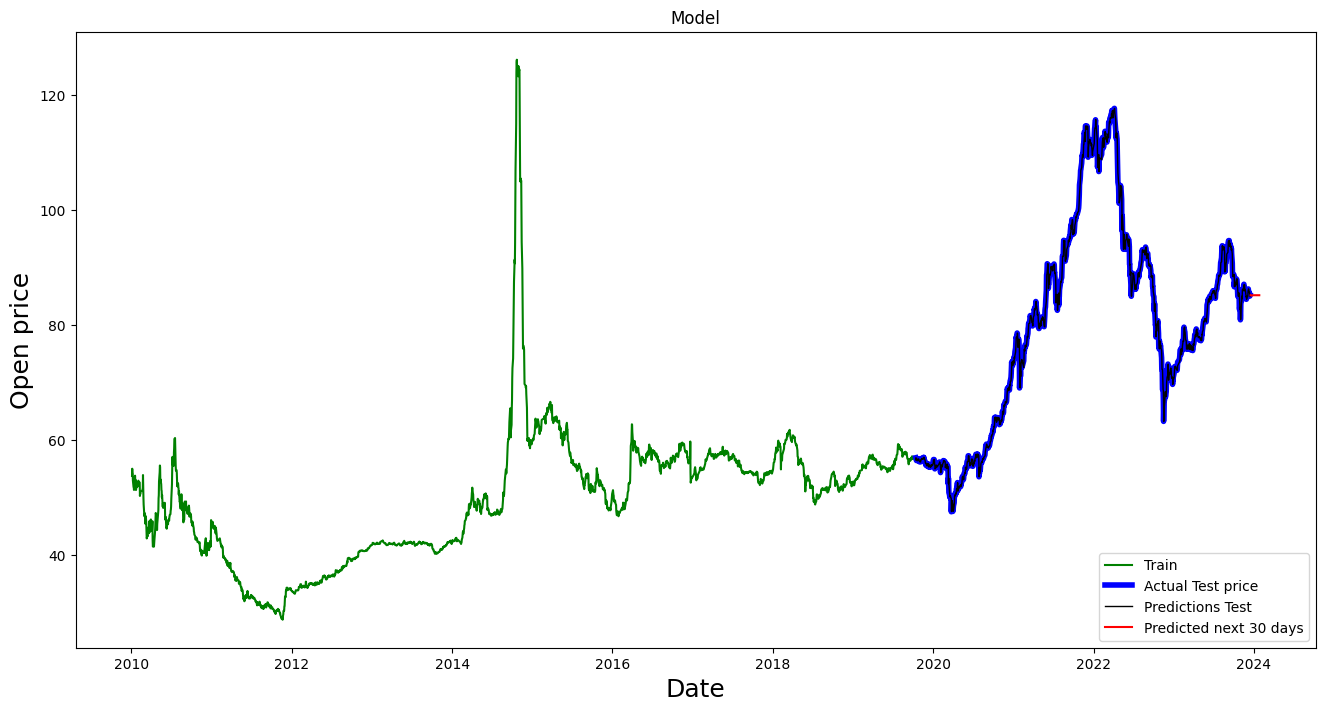

In [19]:
predicted_date = create_weekdays_december_january_dataframe()
future_30_days_df = pd.DataFrame(future_30_days, index=predicted_date["Date"], columns=["Open"])
future_30_days_df.index = pd.to_datetime(future_30_days_df.index)

plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Open price', fontsize=18)
plt.plot(train_data['Date'],train_data['Open'], color='green')
plt.plot(test_data['Date'],test_data[['Open']], color='blue', lw=4)
plt.plot(predicted_df['Date'], predicted_df['Open'], color='black',lw=1)
plt.plot(future_30_days_df.index, future_30_days_df['Open'], label='Predicted next 30 days', color = 'red')
plt.legend(['Train', 'Actual Test price', 'Predictions Test', 'Predicted next 30 days'], loc='lower right')
plt.show()